<a href="https://colab.research.google.com/github/Gosiuniunia/uczenie-glebokie/blob/main/attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Źródła:

Gu, Jindong, et al. "A survey on transferability of adversarial examples across deep neural networks." arXiv preprint arXiv:2310.17626 (2023).

Podder, Rakesh, and Sudipto Ghosh. "Impact of white-box adversarial attacks on convolutional neural networks." 2024 International Conference on Emerging Trends in Networks and Computer Communications (ETNCC). IEEE, 2024.

Qin, Yunxiao, et al. "Training meta-surrogate model for transferable adversarial attack." Proceedings of the AAAI conference on artificial intelligence. Vol. 37. No. 8. 2023.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchattacks
!pip install sewar

  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.6-py3-none-any.whl size=11418 sha256=99fb9324320abc19d5f1ed5dc20e4e10a910b49ac4b621b7d87fe93a1d1edd65
  Stored in directory: /root/.cache/pip/wheels/fb/4e/29/b15a3d425c5f0fe8f461cbfdaf4fa98ef203fed97ce1df6695
Successfully built sewar


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from PIL import Image
import sewar
import pandas as pd
from torch.utils.data import DataLoader

seed = 42
random.seed(seed)
torch.manual_seed(seed)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
vgg_model_path = "/content/drive/MyDrive/vgg_epoch_80.pth"
resnet_model_path = "/content/drive/MyDrive/model_ResNet18_cifar10_20251112.pth"
images_save_folder_path = "/content/drive/MyDrive/adv_files" # "/content/drive/MyDrive/" is mandatory

In [ ]:
# Preparing VGG model
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Blok 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256*4*4, 512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        # x = self.block5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model_vgg = VGG16(num_classes=10)
model_vgg.load_state_dict(torch.load(vgg_model_path, map_location=device))
model_vgg.to(device)
model_vgg.eval()


VGG16(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

In [ ]:
# Preparing ResNet18 model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, input_channels, output_channels, stride=1):
        super().__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3,
                      stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or input_channels != output_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.main_path(x) + self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = nn.Sequential(
            BasicBlock(input_channels=64, output_channels=64, stride=1),
            BasicBlock(input_channels=64, output_channels=64, stride=1)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(input_channels=64, output_channels=128, stride=2),
            BasicBlock(input_channels=128, output_channels=128, stride=1)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(input_channels=128, output_channels=256, stride=2),
            BasicBlock(input_channels=256, output_channels=256, stride=1)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(input_channels=256, output_channels=512, stride=2),
            BasicBlock(input_channels=512, output_channels=512, stride=1)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.stem(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.classifier(out)
        return out


model_resnet = ResNet18(3, 10)
model_resnet.load_state_dict(torch.load(resnet_model_path, map_location=device))
model_resnet.to(device)
model_resnet.eval()

ResNet18(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (main_path): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (main_path): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
# Dataset
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
]) # only one transform is used because augumentation is not taken into consideration when generating attacks

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [ ]:
# Helper functions

def predict(model, images):
    with torch.no_grad():
        _, pred = model(images).max(1)
    return pred

def choose_images(n_examples, dataset, model):
  """
  This function chooses a random sample of given size from given dataset.
  It returns those that were correctly classified by the given model.
  """

  indices = random.sample(range(len(dataset)), n_examples)
  data_samples = [testset[i] for i in indices]

  adv_images = torch.stack([x[0] for x in data_samples])
  adv_labels = torch.tensor([x[1] for x in data_samples])
  adv_images, adv_labels = adv_images.to(device), adv_labels.to(device)

  model_pred = predict(model, adv_images)
  correct_mask = model_pred.eq(adv_labels)
  adv_images = adv_images[correct_mask]
  adv_labels = adv_labels[correct_mask]

  print(f"Original batch size: {n_examples}")
  print(f"Number of correctly classified examples: {adv_images.size(0)}")

  return adv_images, adv_labels

In [ ]:
# Samples and attack generation
# Adversarial attacks PyTorch: https://github.com/Harry24k/adversarial-attacks-pytorch/tree/master
from torchattacks import PGD, FGSM, CW # more attacks will be added

# Parameters
n_examples = 1000
dataset = testset
attacking_model = model_vgg

images, labels = choose_images(n_examples, dataset, attacking_model)

atk_fgsm = FGSM(attacking_model, eps=8/255)
atk_fgsm.set_normalization_used(mean, std)
adv_images_fgsm = atk_fgsm(images, labels)

atk_pgd = PGD(attacking_model, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_pgd.set_normalization_used(mean, std)
adv_images_pgd = atk_pgd(images, labels)

atk_cw = CW(attacking_model, c=0.1, steps=1000, lr=0.01)
atk_cw.set_normalization_used(mean, std)
adv_images_cw = atk_cw(images, labels)


Original batch size: 1000
Number of correctly classified examples: 871


In [ ]:
vgg_pred_fgsm = predict(model_vgg, adv_images_fgsm)
vgg_pred_pgd = predict(model_vgg, adv_images_pgd)
vgg_pred_cw = predict(model_vgg, adv_images_cw)

resnet_pred = predict(model_resnet, images)
resnet_pred_fgsm = predict(model_resnet, adv_images_fgsm)
resnet_pred_pgd = predict(model_resnet, adv_images_pgd)
resnet_pred_cw = predict(model_resnet, adv_images_cw)

In [ ]:
# Attack efficiency metrics

def attack_success_rate(labels, preds):
    """
    Computes the Attack Success Rate (ASR).
    Measures how many attacks succeeded.
    """
    total = len(labels)
    succeeded = (preds != labels).sum().item()
    return 100.0 * succeeded / total

def fooling_rate(labels, source_pred, target_pred, clean_target_pred):
    """
    Computes the fooling rate for transfer attacks.

    - source_pred: predictions of the SOURCE model on adversarial images
    - target_pred: predictions of the TARGET model on adversarial images
    - clean_target_pred: predictions of the TARGET model on clean images

    We measure cases where:
    1) the adversarial sample fools the SOURCE model,
    2) it also fools the TARGET model,
    3) but the TARGET classified the clean version correctly.

    The fooling rate is: Q / P
    where:
        P = number of samples that fooled the source
        Q = number of samples that fooled both models
    """
    fool_source = source_pred != labels
    fool_target = target_pred != labels
    correct_target_clean = clean_target_pred == labels

    P = fool_source.sum().item()
    Q = (fool_source & fool_target & correct_target_clean).sum().item()

    return 100.0 * Q / P if P > 0 else 0.0

def same_mistake_rate(labels, source_pred, target_pred, clean_target_pred):
    """
    Computes the rate at which both the source and target models make
    the SAME wrong prediction on adversarial samples.

    We consider ONLY samples where:
    - the target model classified the CLEAN image correctly
    - the target model is fooled on the adversarial image

    Among those, we measure how often:
        source_pred == target_pred (same incorrect class)
    """
    correct_target_clean = clean_target_pred == labels
    fool_target = target_pred != labels
    same_mistake = source_pred == target_pred

    mask = fool_target & correct_target_clean
    denom = mask.sum().item()

    if denom == 0:
        return 0.0

    num = (mask & same_mistake).sum().item()
    return 100.0 * num / denom

# Perturbation quality metrics

def ssim(images, adv_images):
    """
    Computes the mean Structural Similarity Index (SSIM)
    between original and adversarial images.

    SSIM measures perceptual similarity considering:
    - luminance
    - contrast
    - structure

    SSIM = 1 means identical images.
    Lower values indicate stronger or more visible perturbations.
    """
    ssim_list = []

    for i in range(images.size(0)):
        img_1 = images[i].permute(1, 2, 0).detach().cpu().numpy()
        img_2 = adv_images[i].permute(1, 2, 0).detach().cpu().numpy()

        img_1 = (img_1 * 255).clip(0, 255).astype(np.uint8)
        img_2 = (img_2 * 255).clip(0, 255).astype(np.uint8)

        ssim_val, _ = sewar.ssim(img_1, img_2)
        ssim_list.append(ssim_val)

    return float(np.mean(ssim_list))


In [ ]:
# Metric values
"""
ASR - ile % ataków się udało
Fooling rate - ile % ataków co zmyliło source zmyliło też target
Same mistake - ile % to był ten sam błąd
wszystko pod warunkiem że target poprawnie sklasyfikował oryginał
"""

# ResNet ASR is counted only when clean images are classified correctly

correct_mask_resnet = resnet_pred.eq(labels)
print(f"Number of correctly classified examples for ResNet: {correct_mask_resnet.sum()}")
attack_metrics = {
    "Attack": ["FGSM", "PGD", "CW"],
    "VGG ASR": [
        attack_success_rate(labels, vgg_pred_fgsm),
        attack_success_rate(labels, vgg_pred_pgd),
        attack_success_rate(labels, vgg_pred_cw)
    ],
    "ResNet ASR": [
        attack_success_rate(labels[correct_mask_resnet], resnet_pred_fgsm[correct_mask_resnet]),
        attack_success_rate(labels[correct_mask_resnet], resnet_pred_pgd[correct_mask_resnet]),
        attack_success_rate(labels[correct_mask_resnet], resnet_pred_cw[correct_mask_resnet])
    ],
    "Fooling Rate (VGG -> ResNet)": [
        fooling_rate(labels, vgg_pred_fgsm, resnet_pred_fgsm, resnet_pred),
        fooling_rate(labels, vgg_pred_pgd, resnet_pred_pgd, resnet_pred),
        fooling_rate(labels, vgg_pred_cw, resnet_pred_cw, resnet_pred)
    ],
    "Same Mistake Rate (VGG -> ResNet)": [
        same_mistake_rate(labels, vgg_pred_fgsm, resnet_pred_fgsm, resnet_pred),
        same_mistake_rate(labels, vgg_pred_pgd, resnet_pred_pgd, resnet_pred),
        same_mistake_rate(labels, vgg_pred_cw, resnet_pred_cw, resnet_pred)
    ]
}

df_attack = pd.DataFrame(attack_metrics)
print("=== Attack Efficiency Metrics ===")
print(df_attack)

print("=== SSIM values ===")
print("SSIM for FGSM:", ssim(images, adv_images_fgsm))
print("SSIM for PGD:", ssim(images, adv_images_pgd))
print("SSIM for CW:", ssim(images, adv_images_cw))

Number of correctly classified examples for ResNet: 853
=== Attack Efficiency Metrics ===
  Attack     VGG ASR  ResNet ASR (originally correct only)  \
0   FGSM   94.718714                             47.479484   
1    PGD  100.000000                             64.009379   
2     CW  100.000000                              1.758499   

   Fooling Rate (VGG -> ResNet)  Same Mistake Rate (VGG -> ResNet)  
0                     48.969697                          63.950617  
1                     62.686567                          95.970696  
2                      1.722158                          86.666667  
=== SSIM values ===
SSIM for FGSM: 0.9369262695741961
SSIM for PGD: 0.9582249748340417
SSIM for CW: 0.998044740450877


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

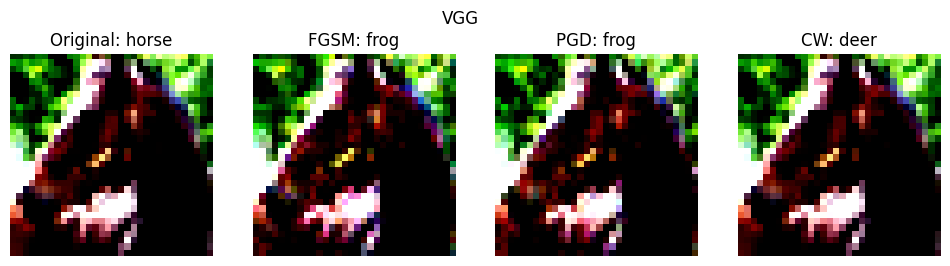

In [ ]:
# Wisualization of one sample for VGG prediction
index = 3 # Index number must be lower than correctly classified examples
class_names = testset.classes

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
fig.suptitle("VGG")
axs[0].imshow((images[index].permute(1, 2, 0).cpu().detach().numpy()* 255).clip(0, 255).astype(np.uint8))
axs[0].set_title(f"Original: {class_names[labels[index]]}")
axs[0].axis('off')

axs[1].imshow((adv_images_fgsm[index].permute(1, 2, 0).cpu().detach().numpy()* 255).clip(0, 255).astype(np.uint8))
axs[1].set_title(f"FGSM: {class_names[vgg_pred_fgsm[index]]}")
axs[1].axis('off')

axs[2].imshow((adv_images_pgd[index].permute(1, 2, 0).cpu().detach().numpy()* 255).clip(0, 255).astype(np.uint8))
axs[2].set_title(f"PGD: {class_names[vgg_pred_pgd[index]]}")
axs[2].axis('off')

axs[3].imshow((adv_images_cw[index].permute(1, 2, 0).cpu().detach().numpy()* 255).clip(0, 255).astype(np.uint8))
axs[3].set_title(f"CW: {class_names[vgg_pred_cw[index]]}")
axs[3].axis('off')

In [ ]:
# Save images to the designated folder

def save_images(images, labels, path, folder_name=None):
  """
  This function saves given images with their labels in the given folder.
  Subfolder can be specified. Each image is saved as adv_image_{index}_label_{labels[index]}.png,
  """
  try:
    path = os.path.join(path, folder_name)
  except:
    pass

  os.makedirs(path, exist_ok=True)

  for i, (image_tensor, label) in enumerate(zip(images, labels)):
    image_np = (images[i].permute(1, 2, 0).cpu().detach().numpy()* 255).clip(0, 255).astype(np.uint8)
    image_pil = Image.fromarray(image_np)

    filename = f"adv_image_{i}_label_{labels[i]}.png"
    filepath = os.path.join(path, filename)
    image_pil.save(filepath)


In [ ]:
save_images(adv_images_pgd, labels, images_save_folder_path, "pgd")

In [ ]:
# Loading all of the images in specified folder to torch dataset

from torch.utils.data import Dataset

class AdversarialImageDataset(Dataset):
    """
    This class loads the images from specified folder (save_images generated folder)
    and transforms it to torch dataset for future learning.
    """

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []

        for file in os.listdir(root_dir):
            if file.endswith(".png"):
                self.image_files.append(file)

        self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        path = os.path.join(self.root_dir, img_name)

        image = Image.open(path).convert("RGB")
        label = int(img_name.split("_")[-1].split(".")[0])

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# How to load the adversarial dataset and dataloader for additional training

subfolder_name = "pgd"
dataset_pgd = AdversarialImageDataset(root_dir=os.path.join(images_save_folder_path, subfolder_name), transform=transform)
loader_pgd = DataLoader(dataset_pgd, batch_size=10, shuffle=False)

In [ ]:
# How to get images and labels for metrics

adv_images = torch.stack([x[0] for x in dataset_pgd])
adv_labels = torch.tensor([x[1] for x in dataset_pgd])
adv_images, adv_labels = adv_images.to(device), adv_labels.to(device)

model_pred = predict(model_vgg, adv_images)
print(adv_labels[:5].cpu().tolist(), model_pred[:5].cpu().tolist())

[9, 4, 0, 2, 1] [1, 0, 2, 6, 8]
